<a href="https://www.kaggle.com/code/rodrigofardin/dog-breed-identification?scriptVersionId=133291500" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
#Importing required libraries
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

import tensorflow as tf
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [3]:
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))


#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))

Total unique breed 120


In [5]:
input_shape = (331,331,3)

def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix] = img
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images, y

In [6]:
import time 
t = time.time()

X, y = images_to_array('/kaggle/input/dog-breed-identification/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 102.97455739974976


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7155, 331, 331, 3) (7155, 120)
(3067, 331, 331, 3) (3067, 120)


In [8]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
# Hyperparameters
batch_size= 128
epochs=25
learn_rate=.001
sgd=SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [10]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [11]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X_train)

print('Inception feature maps shape', inception_features.shape)

224/224 [==============================] - 1021s 5s/step
Feature maps shape:  (7155, 2048)
Inception feature maps shape (7155, 2048)


In [12]:
del X, X_train #to free up some ram memory
gc.collect()

38540

In [15]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(inception_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(inception_features, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr, EarlyStop])

Epoch 1/25
45/45 [==============================] - 1s 13ms/step - loss: 3.6054 - accuracy: 0.3085 - val_loss: 1.8853 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - 0s 10ms/step - loss: 1.3691 - accuracy: 0.7867 - val_loss: 0.7630 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - 0s 11ms/step - loss: 0.7062 - accuracy: 0.8677 - val_loss: 0.5116 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 4/25
45/45 [==============================] - 0s 10ms/step - loss: 0.5045 - accuracy: 0.8915 - val_loss: 0.4108 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 5/25
45/45 [==============================] - 0s 9ms/step - loss: 0.4099 - accuracy: 0.9039 - val_loss: 0.3712 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 6/25
45/45 [==============================] - 0s 8ms/step - loss: 0.3624 - accuracy: 0.9043 - val_loss: 0.3379 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 7/25
45/45 [==============================] - 0s 9ms/step - loss: 0.3107

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 120)               245880    
                                                                 
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________


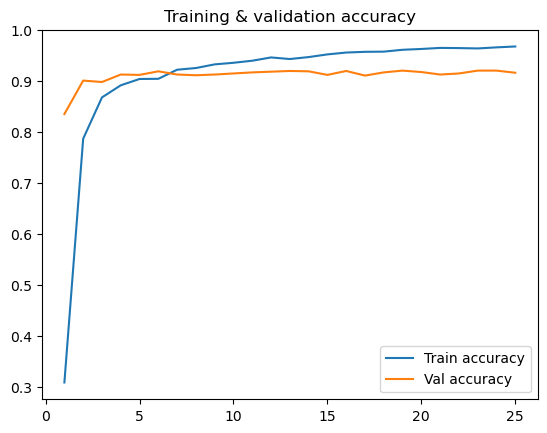

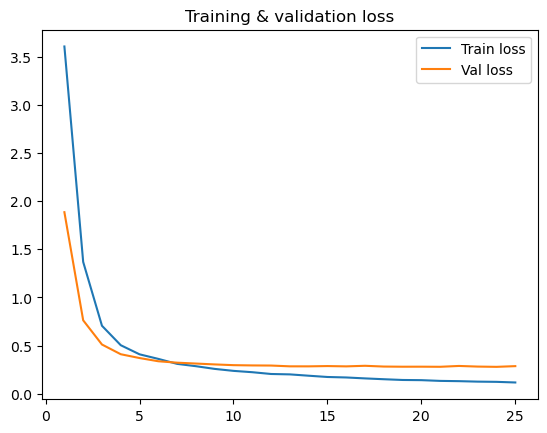

In [18]:
# Plot result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Val accuracy')
plt.title('Training & validation accuracy')
plt.legend()

# Loss
plt.figure()
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.title('Training & validation loss')
plt.legend()
plt.show()

In [19]:
del inception_features
gc.collect()

12645

In [20]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    print('Inception feature maps shape', inception_features.shape)
    return inception_features

test_features = extact_features(X_test)

96/96 [==============================] - 457s 5s/step
Feature maps shape:  (3067, 2048)
Inception feature maps shape (3067, 2048)


In [21]:
y_pred = model.predict(test_features)

96/96 [==============================] - 0s 2ms/step


In [22]:
from sklearn.metrics import accuracy_score

y_test_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

accuracy_score(y_test_indices, y_pred_indices)

0.9074013694163677